#Imports

In [127]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [128]:
from datetime import date
today = date.today()
stock_data = yf.download('ORCL', start='2022-01-01', end=today)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,87.330002,87.940002,85.760002,87.900002,85.719147,10644400
2022-01-04,87.900002,89.580002,87.730003,88.839996,86.635811,11959000
2022-01-05,88.489998,88.599998,86.220001,86.459999,84.314865,11236700
2022-01-06,86.000000,87.419998,85.550003,86.339996,84.510628,7918400
2022-01-07,86.449997,88.000000,86.279999,87.510002,85.655846,9836800


#Past Evaluations


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date'], dtype='object')


<Axes: xlabel='Date'>

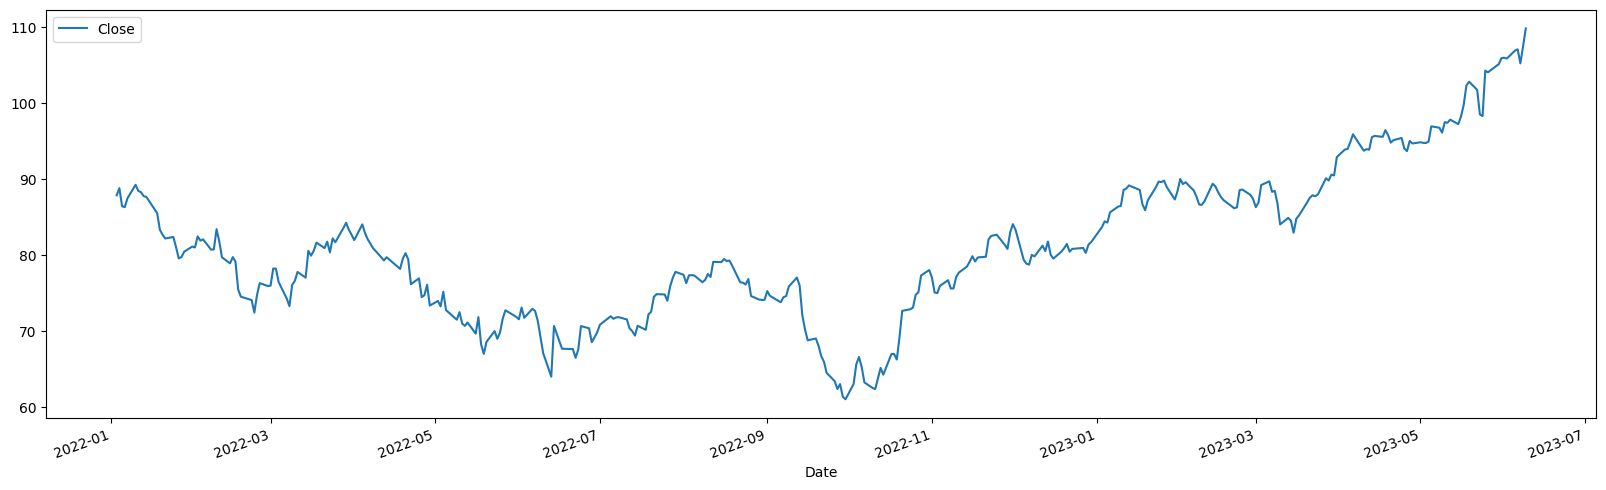

In [129]:
# Creating a column as date
stock_data['Date']=stock_data.index
print(stock_data.columns)
 
# Plotting the stock prices
%matplotlib inline
stock_data.plot(x='Date', y='Close', kind='line', figsize=(20,6), rot=20)

#Data Extraction and Testing PQs

In [130]:
# Extracting the closing prices of each day
FullData=stock_data[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[87.90000153]
 [88.83999634]
 [86.45999908]
 [86.33999634]
 [87.51000214]]
### After Normalization ###


array([[0.55002055],
       [0.56929064],
       [0.52050021],
       [0.51804012],
       [0.54202548]])

In [131]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(351, 10, 1)

#### Output Data shape ####
(351, 1)


In [132]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(346, 10, 1)
(346, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [133]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.55002055]
 [0.56929064]
 [0.52050021]
 [0.51804012]
 [0.54202548]
 [0.57831078]
 [0.56191071]
 [0.55842555]
 [0.54776552]
 [0.54571553]] -- [0.5018451]
[[0.56929064]
 [0.52050021]
 [0.51804012]
 [0.54202548]
 [0.57831078]
 [0.56191071]
 [0.55842555]
 [0.54776552]
 [0.54571553]
 [0.5018451 ]] -- [0.45735953]


In [134]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


#Training Dataset

In [135]:


# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
70/70 [==============================] - 6s 16ms/step - loss: 0.0701
Epoch 2/100
70/70 [==============================] - 2s 22ms/step - loss: 0.0064
Epoch 3/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0044
Epoch 4/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0041
Epoch 5/100
70/70 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 6/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0045
Epoch 7/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0043
Epoch 8/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0040
Epoch 9/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0041
Epoch 10/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 11/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0039
Epoch 12/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0038
Epoch 13/100
70/70 [=====

1/1 [==============================] - 1s 612ms/step
Accuracy: 98.80725349041133


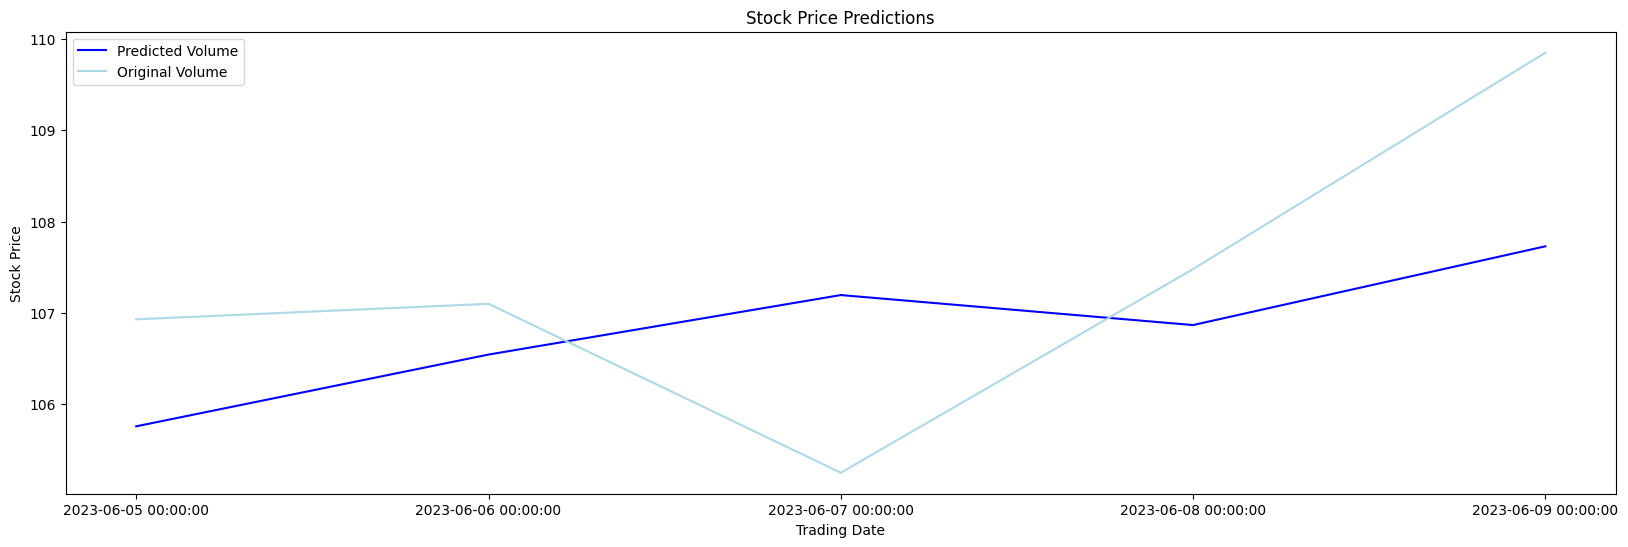

In [136]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), stock_data.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

#LSTM Prediction x Evaluations

1/1 [==============================] - 0s 29ms/step


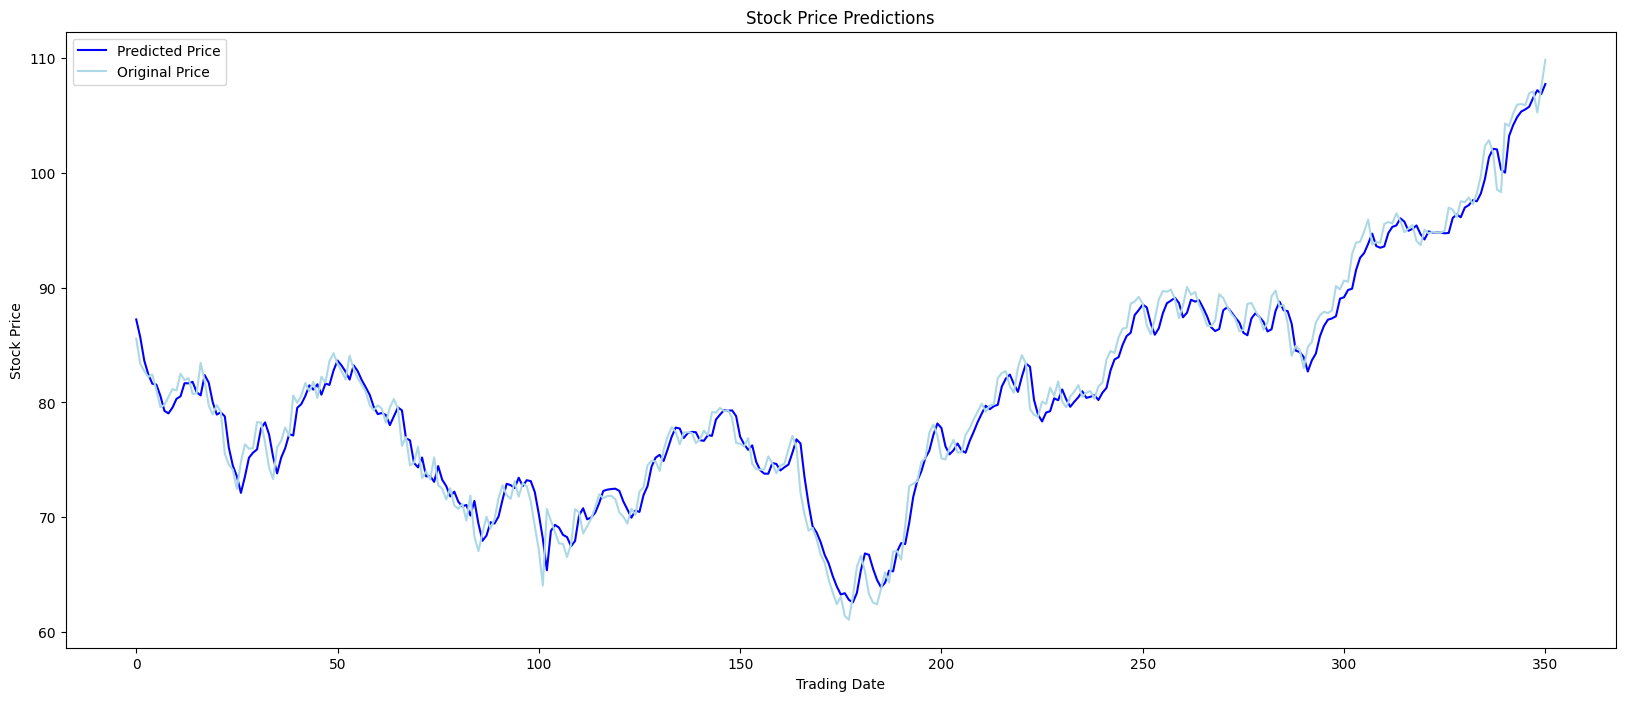

In [137]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

#Prediction for 1 Day Ahead

In [138]:
# Last 10 days prices
Last10Days=FullData[-10:]
print(Last10Days)
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
# Making predictions on data
print("Tomorrow's Prediction")
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

[[104.08000183]
 [105.15000153]
 [105.94000244]
 [105.98999786]
 [105.88999939]
 [106.93000031]
 [107.09999847]
 [105.25      ]
 [107.48000336]
 [109.84999847]]
Tomorrow's Prediction
1/1 [==============================] - 0s 24ms/step


array([[108.921844]], dtype=float32)

# Data Preparation for Multi Step LSTM - 5 Day Predictive Index

In [139]:
# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])
 
print('###################')
 
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[104.08000183]
 [105.15000153]
 [105.94000244]
 [105.98999786]
 [105.88999939]
 [106.93000031]
 [107.09999847]
 [105.25      ]
 [107.48000336]
 [109.84999847]]
###################
Scaled Prices
[0.88171388 0.9036491  0.91984428 0.92086919 0.9188192  0.94013944
 0.94362443 0.90569909 0.95141461 1.        ]


In [140]:
 # split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(346, 10, 1)
### Output Data Shape ###
(346, 5)


In [141]:

# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(341, 10, 1)
(341, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


In [142]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.55002055]
 [0.56929064]
 [0.52050021]
 [0.51804012]
 [0.54202548]
 [0.57831078]
 [0.56191071]
 [0.55842555]
 [0.54776552]
 [0.54571553]]
====>
[0.5018451  0.45735953 0.44382948 0.43357938 0.43767936]
####################
[[0.56929064]
 [0.52050021]
 [0.51804012]
 [0.54202548]
 [0.57831078]
 [0.56191071]
 [0.55842555]
 [0.54776552]
 [0.54571553]
 [0.5018451 ]]
====>
[0.45735953 0.44382948 0.43357938 0.43767936 0.41000411]
####################


#Deep Learning Multi-Step LSTM model

In [143]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [144]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
69/69 [==============================] - 6s 18ms/step - loss: 0.1502
Epoch 2/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0556
Epoch 3/100
69/69 [==============================] - 1s 18ms/step - loss: 0.0196
Epoch 4/100
69/69 [==============================] - 2s 23ms/step - loss: 0.0097
Epoch 5/100
69/69 [==============================] - 2s 22ms/step - loss: 0.0079
Epoch 6/100
69/69 [==============================] - 2s 26ms/step - loss: 0.0079
Epoch 7/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0071
Epoch 8/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0073
Epoch 9/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0067
Epoch 10/100
69/69 [==============================] - 1s 17ms/step - loss: 0.0065
Epoch 11/100
69/69 [==============================] - 1s 18ms/step - loss: 0.0063
Epoch 12/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0062
Epoch 13/100
69/69 [=====

In [145]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

1/1 [==============================] - 1s 689ms/step
#### Predicted Prices ####
[[100.33272  101.41081  102.588936 102.406685 101.23358 ]
 [101.313515 102.404175 103.52949  103.34634  102.1699  ]
 [102.242676 103.423004 104.588806 104.38025  103.09018 ]
 [103.233536 104.49798  105.73589  105.503174 104.10165 ]
 [103.90152  105.20959  106.53239  106.286705 104.82049 ]]

#### Original Prices ####
[[104.08000183 105.15000153 105.94000244 105.98999786 105.88999939]
 [105.15000153 105.94000244 105.98999786 105.88999939 106.93000031]
 [105.94000244 105.98999786 105.88999939 106.93000031 107.09999847]
 [105.98999786 105.88999939 106.93000031 107.09999847 105.25      ]
 [105.88999939 106.93000031 107.09999847 105.25       107.48000336]]


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date'], dtype='object')


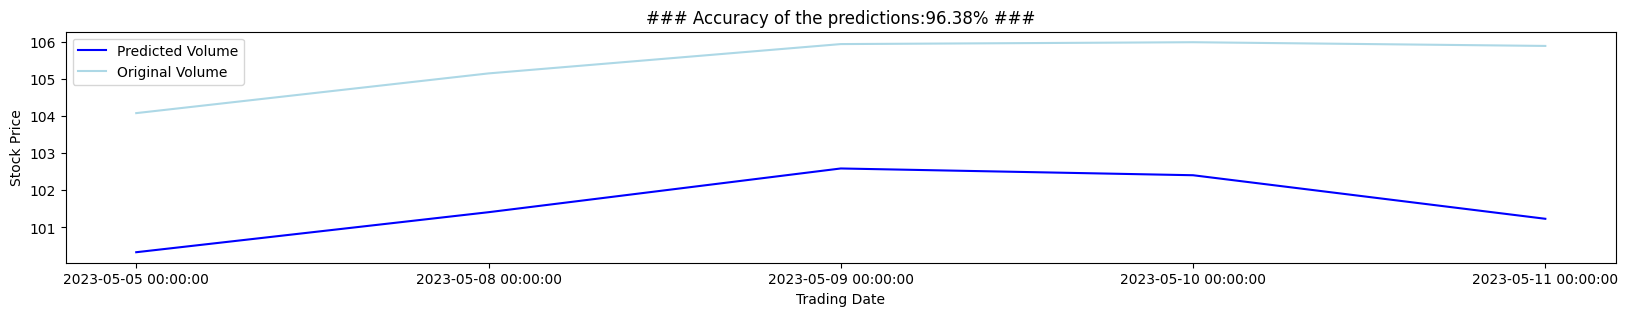

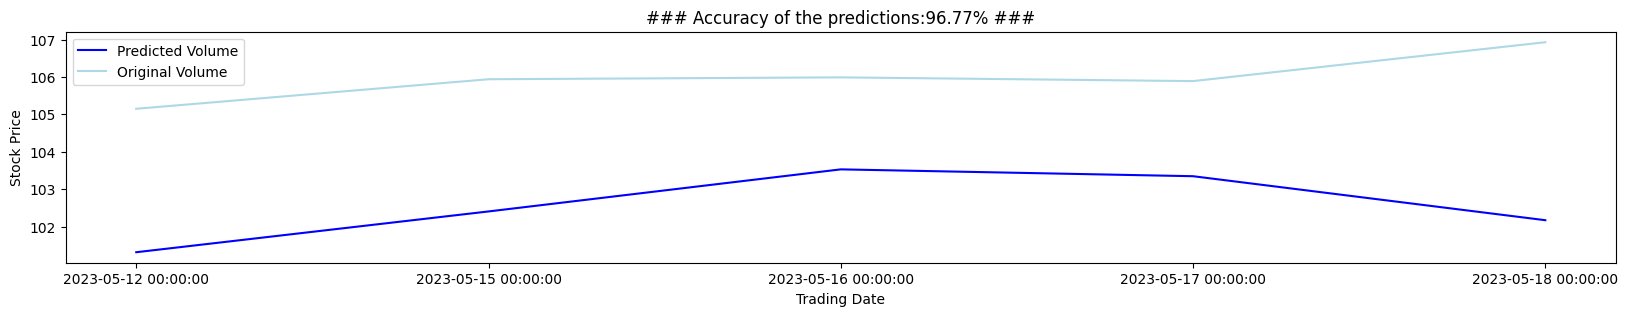

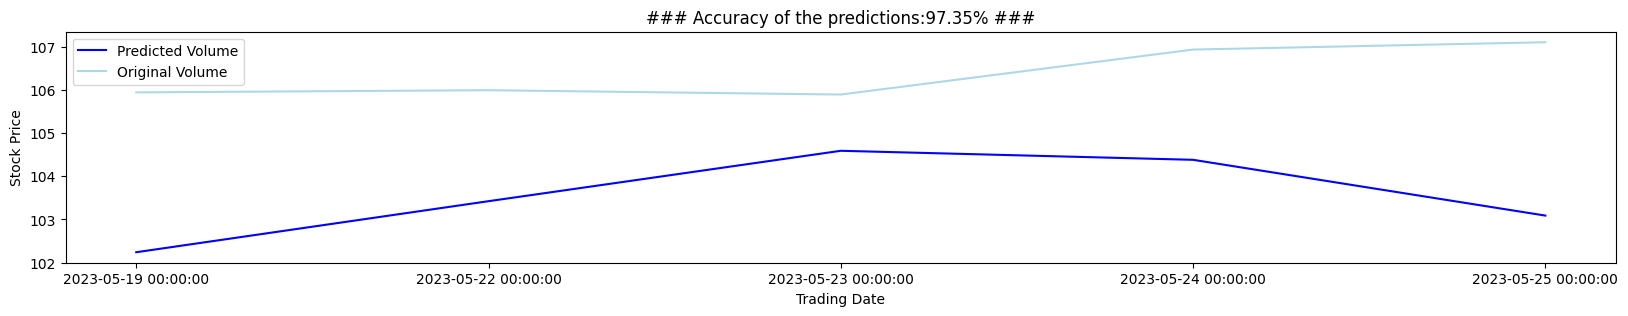

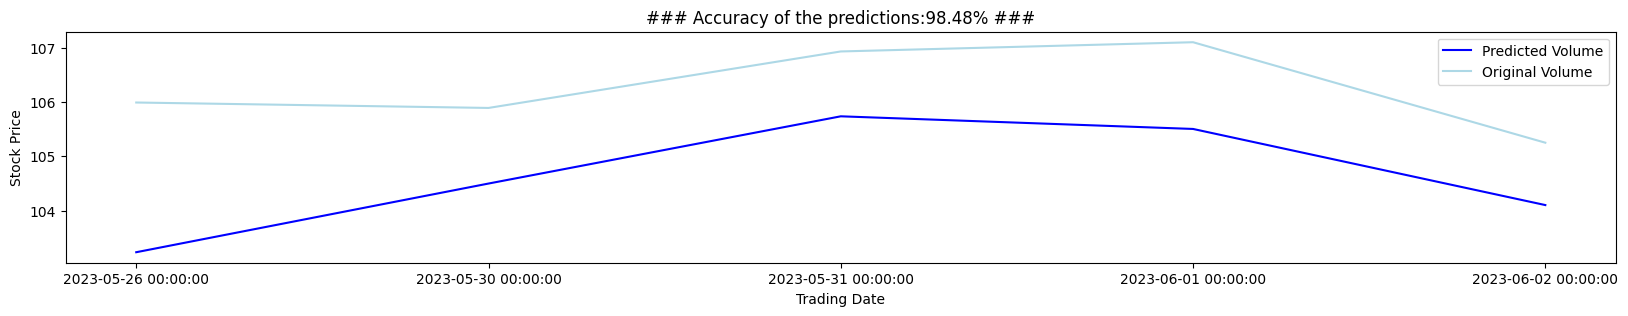

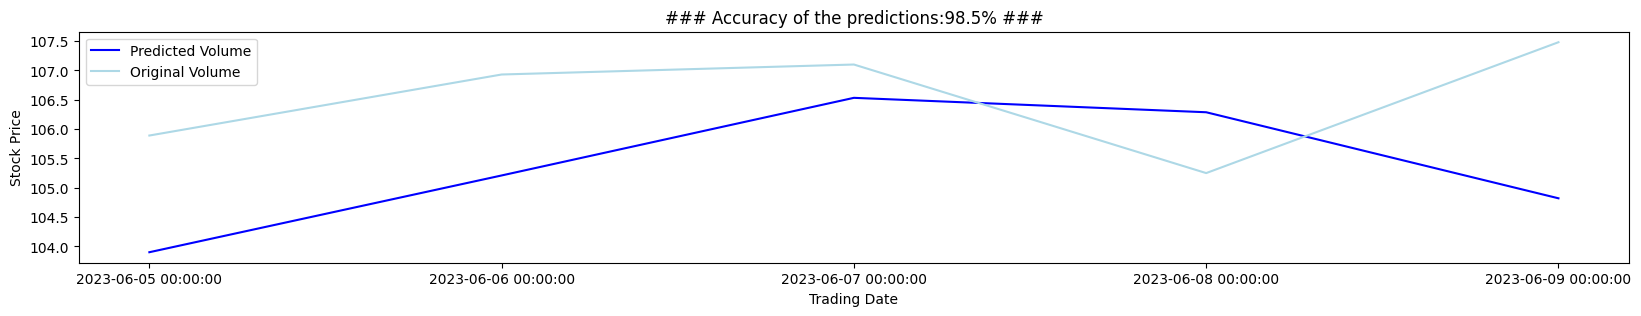

In [146]:
import matplotlib.pyplot as plt

stock_data['Date']=stock_data.index
print(stock_data.columns)

for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=stock_data.shape[0]
 
    plt.xticks(range(FutureTimeSteps), stock_data.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Date'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

In [147]:
# Making predictions on test data
Last10DaysPrices= FullData[-10:]
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

1/1 [==============================] - 0s 35ms/step


array([[107.16104 , 109.017525, 110.83597 , 110.426   , 108.21626 ]],
      dtype=float32)